
<h1><center> A CRYPTOCURRENCY TRADING MODEL </center></h1>

<h2><i><center> USING KERAS AND SCIKIT </center></i></h2>



## 1. MOTIVATION AND SOURCE

This section is based on Emura, H(2019) "Training and evaluating neural networks for cryptocurrency trading using keras and scikit-learn" from https://medium.com/datadriveninvestor/training-and-evaluating-neural-networks-for-cryptocurrency-trading-using-keras-and-scikit-learn-5c6a229a3a6b

Have you ever wondered if it would be possible to use deep learning for algorithmic trading? This tutorial will show you how to build a deep learning model for cryptocurrency trading with keras and scikit-learn and explain why the seemingly profitable model is not exactly a money-making machine. It assumes that the reader has a basic understanding of Python and machine learning. 

The data set that we’re going to use is one-minute price and volume data for NEO/BTC from 2018/1/1 through 2018/12/31 stored as a csv file. In a one minute chart, one bar represents the price range of a one-minute interval. The volume is the number of coins that were traded during the time interval. In this tutorial, only the close price and the volume will be used. The original data looks like this.

#### FORECASTING SEEN AS A CLASSIFICATION PROBLEM

Most tutorials for cryptocurrency/stock/forex price prediction treat it as a regression problem. In this tutorial, we will formulate it as a binary classification problem(long/neutral). ***This means we’re going to use cross-entropy as the loss function instead of MSE(mean squared error).*** is trivial to extend it to multi-class classification(For example, long/neutral/short). In an image classification problem, each training sample consists of an image and a category. In this time series classification problem, what should the training examples look like?

$x =$ (yesterday’s price, yesterday’s volume).

$y =$ 1(long) if the price increases the next day(or n days/minutes/seconds later) 0(neutral) otherwise.

This is one way to do it, but you won’t achieve state of the art accuracy this way because it is a well-known fact that the market has a long memory. This means we should use a history of prices and volumes instead of just one(moving windows of data). For this reason, we are going to use the data from the previous n bars(in our case, n minutes) to predict the price movement m bars into the future. In other words, our x and y should like this

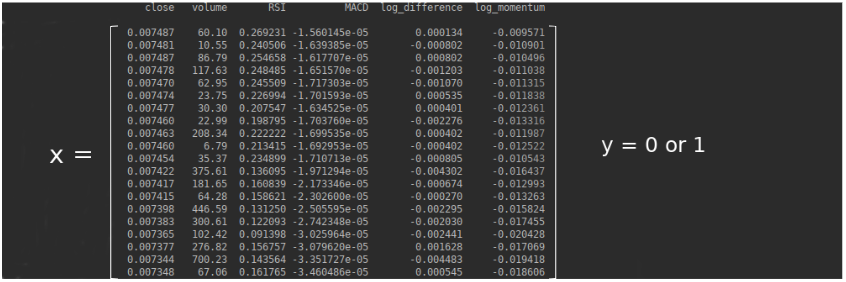

## 2. LOADING THE DATA SET

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()

In [1]:
import time
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('NEOBTC.csv', index_col='timestamp')


#### TECHNICAL INDICATORS FOR NETWORK TRAINING
Most traders make use of trading indicators such as MACD to make trading decisions. We will compute the following indicators and use them as training data.


- MACD(20 minute(bar) exponential average minus 10 minute(bar) exponential average)
- Log Momentum(m=20 minute(bar) difference in log price)
- Log Price Difference(1 minute(bar) difference in log price, a special case of log momentum)
- Each of these will become a column of the data frame. The functions for computing the indicators are shown below.


In [3]:
def exponential_moving_average(ps, look_back):
    return ps.ewm(span=look_back, min_periods=0, adjust=False, ignore_na=True).mean()


def macd(ps, short, long):
    short_ema = exponential_moving_average(ps, short)
    long_ema = exponential_moving_average(ps, long)
    return short_ema - long_ema

def log_momentum(ps, m):
    log_price = np.log(ps)
    shifted_log_price = log_price.shift(m)
    return log_price - shifted_log_price

def log_difference(ps):
    return log_momentum(ps, 1)




All of these indicators depend on the current and past prices, which means that the first few rows will be NaNs. These NaNs will be removed. 

Another important point is that you should never use python loops in functions like these because it would be over 100 times slower.

## 3. LABELING

#### BASIC LABELING CRITERION

Obviously, you want the model to generate a long signal(1) when the price increases.
More formally,

$y(t) = 1$  if $(p_{t + m} / p_{t — 1})$ threshold (minimum percent increase)

where $p_{t}$ is the price series, $n$ is the forecast horizon. Consider $p_{t + m}$ as the price of the instrument $m$ minutes later)


#### CONSIDERATIONS ABOUT COMMISSIONS AND TRADING FEES

In real life, you need to worry about commissions(transaction costs) and slippage, which means the threshold should be higher than 0. If you set it too high, you will end up with an unbalanced data set. (More on this later) For simplicity, this threshold will be set to 0 in this tutorial.

Neural networks don’t do very well with raw data so we will need to standardize the matrix column by column(subtract the mean and divide it by the standard deviation) The below code uses scitkit-learn to standardize the data.

#### LIBRARIES AND HYPERPARAMETERS

We will need the values of several hyperparameters as we move down the solution of the problem. We want to place at the begining of the coding exercise to have them easy to find and to stop worring about them right from the start.

In [4]:
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

#### THE HYPERPARAMETER DICTIONARY

In [5]:
hyperparameter_dict = {
    'kernel_size': 5,
    'dropout': 0.2,
    'n_classes': 2,
    'window_size': 100,
    'validation_ratio': 0.25,
    'batch_size': 512,
    'n_epochs': 1,
    'monitor': 'val_loss',
    'patience': 5,

    'forecast_horizon': 10,
    'learning_rate': 0.001,

    # model-specific hyper parameters
    'model': 'stacked_CNN',
    'n_cnn_layers': 2,
    'n_cnn_blocks': 1,
    'cnn_bn': True,
    'batch_normalization': True,
    'n_filters': 64,
    'fc_layers': [1024, 1024],
    'activation': 'relu',
}

# Extracting values from the hyperparameter dictionary
window_size = hyperparameter_dict['window_size']
forecast_horizon = hyperparameter_dict['forecast_horizon']
n_epochs = hyperparameter_dict['n_epochs']
n_classes = hyperparameter_dict['n_classes']
validation_ratio = hyperparameter_dict['validation_ratio']


#### TRAINIG AND VALIDATION SETS

In [6]:
# Optional Indicator Calculation
price = df['close']
df['MACD'] = macd(price, 10, 20)
df['log_difference'] = log_difference(price)
df['log_momentum'] = log_momentum(price, 20)

# Target Generation
df['shifted_close'] = df['close'].shift(-forecast_horizon)  # The shifted version will have a couple of NaNs
df.dropna(inplace=True)  # Drop the NaNs
df['target'] = (df['shifted_close'] - df['close'] > 0).astype(int)
df.drop(['shifted_close'], axis=1, inplace=True)  # We don't need this column any more

# Isolate the target series
target_series = df['target'].values  # Extract the numpy array inside
df.drop(['target'], axis=1, inplace=True)

# Split
n_train = len(df) - int(validation_ratio * len(df))
train_df, validation_df = df[:n_train], df[n_train:]
train_target, validation_target = target_series[:n_train], target_series[n_train:]

n_features = train_df.shape[1]

# Standardize the matrices
scaler = StandardScaler()
train_sequence = scaler.fit_transform(train_df)
validation_sequence = scaler.transform(validation_df)

#### THE DIMENSION OD THE TRAINING SET

The dimension of the train data is `(523775,5)`, and the dimension of the validation set is `(174591,5)`. The total number of data entries is then, `3,491,830`. As we stagger the samples, then for a window of 100 observations, the total number of entries grows to : `2,438,226,166,780` entries.

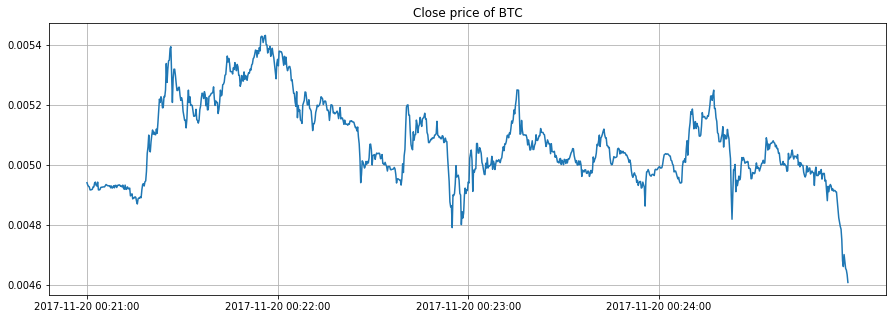

In [7]:
plt.figure(figsize=(15,5))
plt.plot(train_df['close'][1:1000])
plt.grid()
plt.title("Close price of BTC")
plt.locator_params(axis='x', nbins=4)

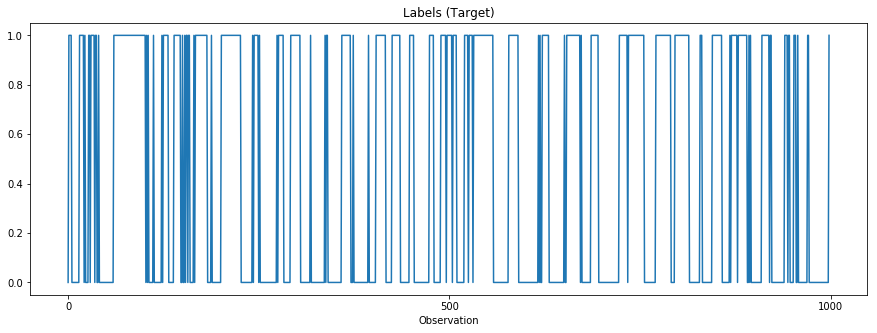

In [8]:
plt.figure(figsize=(15,5))
plt.plot(train_target[1:1000])
plt.title("Labels (Target)")
plt.xlabel("Observation")
plt.locator_params(axis='x', nbins=4)

## 4. CLASS REBALANCING : A NEW AND IMPROVED DATA SAMPLE

#### INDEXING THE DATA WINDOWS


**Depending on the threshold**, the class distribution(long and neutral) can be extremely unbalanced. 

This is problematic because if 99% of the labels are 1, the classifier will simply learn to always output 1 and achieve 99% accuracy, which is completely worthless. 

To prevent that from happening, simple downsampling will be applied to the data set(samples in the overrepresented category will be randomly discarded). You should consider other options such as modifying the loss function and upsampling as well. In order to do this, we will assign a number to each window(Let’s call it window index) as shown in the picture below.

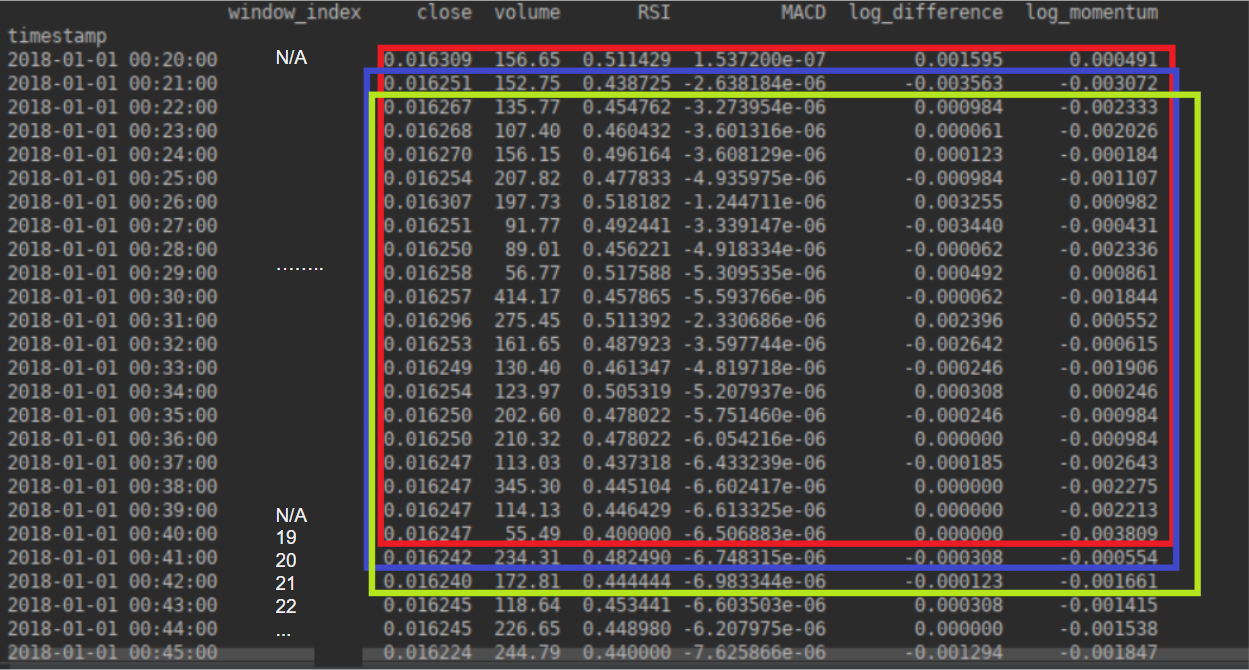

You’re looking at the first 25 rows of the data frame(The window_index column was added for illustration.). The red window is assigned an index of 20, the blue window has index 21, etc. The first 19 rows(row0 through row 18) do not get an index because they don’t have enough history(n is set to 20 here). Window 19 contains rows 0 through 19. Next, we create a list of window indexes and corresponding target values. The following function counts the number of the underrepresented (least frequent) class and randomly removes samples with different class labels to match that number. This function was written for multi-class classification(more than 2 categories) but it works for the binary case as well.

In [9]:
def balance_and_generate_index_lists(sequence, target_series, window_size):
    window_index_dictionary = defaultdict(list)
    unbalanced_window_index_list = []
    downsampled_window_index_list = []

    # Populate the dictionary with window indices
    for i in range(window_size - 1, len(sequence) - window_size + 1):
        window_index_dictionary[target_series[i]].append(i)

    # Create an unbalanced version of the index list
    for cls in window_index_dictionary:
        unbalanced_window_index_list += window_index_dictionary[cls]

    # Figure out the least frequent class
    lengths = [len(index_list_for_class) for index_list_for_class in window_index_dictionary.values()]
    min_length = int(np.min(lengths))

    # Undersampling happens here
    for cls in window_index_dictionary:
        random.shuffle(window_index_dictionary[cls])
        window_index_dictionary[cls] = window_index_dictionary[cls][:min_length]

    # Concatenate the list
    for cls in window_index_dictionary:
        downsampled_window_index_list += window_index_dictionary[cls]

    return downsampled_window_index_list, unbalanced_window_index_list

At this point, both the training set and the validation set are balanced. The function returns the unbalanced window index list as well for future analysis. The balanced version will be fed to the generators for training and validation.

Since we’re using a history of data for prediction, each data point(each row in the data frame) will appear in n different windows or n different examples(n is the size of the moving window). Consequently, consecutive moving windows contain almost identical data. If n is too large and/or the data frame contains many features(in addition to price and volume), this may not fit in memory. For this reason, I created a custom keras generator to generate the moving windows on the fly.(window, label pairs)

### 4.1. CREATE THE CLASS OF MOVING WINDOWS

#### UNDERSTANDING THE DATA

The problem has been reformulated to become similar to an image recognition case.
We have a matrix or a tensor which is associated to a type.

> - We will take several samples.
One sample will have several "images" and these images will be associated with a number.

> - Each sample comes from a previous exercise of randomization. Each random sampling is associated to a list. That list has the sequence corresponding to the observed $X_{j,k}$ and $y_{j,k}$, for $j$ bein the index pof the $k$ sample

> - For each sample we will have a **tensor**. 

> - Each one of the samples will be studied using a ***model*** which will be passed through a CNN.

#### WHY SAMPLING

We will have several samples instead of going for a CNN computed on the whole data.  The reasons explaines before have to do with potential imbalancing.  As with other cases of sampling, the CNN will be calculated for each one and then the results are somewhow averaged to produce the final result.

The construction of the samples requires creating a ***Python object*** that represents the pairs of windows and labels corresponding to each ***sample index***

#### CODE GENERATOR FOR WINDOW LABEL PAIRS

This is the code for the generator that generates window-label pairs on the fly at training time. It is pretty straight-forward but note that sample_index and window_index are two completely different kinds of indexes.
Basically,

- sample_index = 0 corresponds to window_list 0 (The first training sample, which can be any window because we just shuffled the sample index list)
- sample_index = 1 corresponds to window_list 1 (The second training sample)

…and so on

The array is shuffled at the end of each epoch to randomize the order in which training samples appear. After stacking a bunch of samples, the shape of the input tensor is (batch_size, moving_window_size, n_features). At this point, the data is 100% ready.

In [10]:
import json
import random
import os
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from collections import defaultdict
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, confusion_matrix

D:\Program Files\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
class MovingWindowGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, window_size, matrix, target, window_index_list, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.window_index_list = window_index_list
        self.example_index_list = np.arange(len(self.window_index_list))
        self.matrix = matrix
        self.target = target
        self.window_size = window_size  # The size of the moving window
        self.on_epoch_end()  # Randomize the sample order
        self.classes = []

    def __len__(self):
        return int(np.floor(len(self.window_index_list) / self.batch_size))

    def __getitem__(self, index):
        example_indices_for_current_batch = self.example_index_list[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(example_indices_for_current_batch)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.example_index_list)

    def __data_generation(self, example_indexs_for_current_batch):
        X = []
        y = []

        n = self.window_size

        for sample_index in example_indexs_for_current_batch:
            window_index = self.window_index_list[sample_index]
            window = self.matrix[window_index-n+1:window_index+1]  # Extract the window
            target = self.target[window_index]  # Extract the target(y)
            X.append(window)
            y.append(target)

        self.classes += y

        # Convert python lists to numpy arrays
        X, y = np.stack(X), np.stack(y)

        return X, y

### 4.2. CREATE A MODEL BUILDER

This is the function that constructs a simple 1-dimensional convolutional network model with fully connected layers using the hyperparameters in the dictionary. The hyperparameter_dict is a dictionary that contains the hyperparameters for the project. It is important to avoid hard coding values like # of filters, depth of the network, etc to make it easy to find a good network architecture. 

In [12]:
def add_fully_connected_layers(model, hyperparameter_dict):
    fc_layers = hyperparameter_dict['fc_layers']
    activation = hyperparameter_dict['activation']
    n_classes = hyperparameter_dict['n_classes']

    if fc_layers is not None:
        for layer in fc_layers:
            model.add(Dense(layer, activation=activation))
            if 'dropout' in hyperparameter_dict:
                model.add(Dropout(hyperparameter_dict['dropout']))

            if 'batch_normalization' in hyperparameter_dict:
                model.add(BatchNormalization())

    if n_classes > 2:
        model.add(Dense(n_classes, activation='softmax'))
    elif n_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
    else:  # Regression
        model.add(Dense(1))

    return model


def build_simple_CNN(hyperparameter_dict):
    model = Sequential()
    kernel_size = hyperparameter_dict['kernel_size']
    n_filters = hyperparameter_dict['n_filters']
    n_layers = hyperparameter_dict['n_cnn_layers']
    n_blocks = hyperparameter_dict['n_cnn_blocks']

    for i in range(n_blocks):
        for j in range(n_layers):
            params = {
                "filters": n_filters,
                "kernel_size": kernel_size,
                "activation": hyperparameter_dict['activation'],
                "padding": 'same'
            }

            if i == 0 and j == 0:  # Handle the first layer specially
                params['input_shape'] = hyperparameter_dict['input_dim']

            model.add(Conv1D(**params))

            if 'cnn_dropout' in hyperparameter_dict:
                model.add(Dropout(hyperparameter_dict['cnn_dropout']))

            if 'cnn_bn' in hyperparameter_dict:
                model.add(BatchNormalization())

        if 'pool_size' in hyperparameter_dict:
            model.add(MaxPooling1D(pool_size=hyperparameter_dict['pool_size']))

    model.add(Flatten())

    add_fully_connected_layers(model, hyperparameter_dict)

    return model

### 4.3. CREATING ONE SAMPLE

In [13]:
# Downsample and generate moving window indices
train_indices_downsampled, train_indices_unbalanced = balance_and_generate_index_lists(train_sequence,
                                                                                       train_target,
                                                                                       window_size)
validation_indices_downsampled, validation_indices_unbalanced = balance_and_generate_index_lists(validation_sequence,
                                                                                                 train_target,
                                                                                                 window_size)

# Instantiate the moving window generators for each partition
train_gen = MovingWindowGenerator(batch_size=hyperparameter_dict['batch_size'],
                                  window_size=window_size,
                                  matrix=train_sequence,
                                  target=train_target,
                                  window_index_list=train_indices_downsampled)

val_gen = MovingWindowGenerator(batch_size=hyperparameter_dict['batch_size'],
                                window_size=window_size,
                                matrix=validation_sequence,
                                target=validation_target,
                                window_index_list=validation_indices_downsampled)


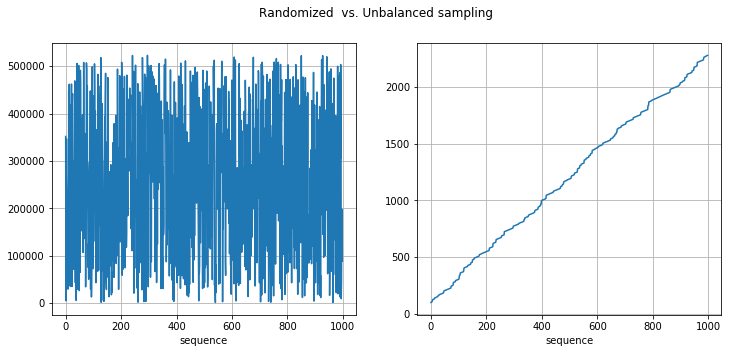

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(train_indices_downsampled[1:1000])
plt.xlabel("sequence")
plt.grid()


plt.subplot(122)
plt.plot(train_indices_unbalanced[1:1000])
plt.xlabel("sequence")
plt.grid()

plt.suptitle('Randomized  vs. Unbalanced sampling')
plt.show()

### 4.4. COMPILATION OF THE MODEL

In [15]:
hyperparameter_dict['input_dim'] = (window_size, n_features)

# Construct a model using the hyper parameter dictionary
model = build_simple_CNN(hyperparameter_dict)

optimizer = Adam(lr=hyperparameter_dict['learning_rate'])

assert(n_classes > 1)

loss = 'sparse_categorical_crossentropy' if n_classes > 2 else 'binary_crossentropy'

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

timestamp = time.time()
model_file_name = f'model-{timestamp}'
save_dir = f'model-{timestamp}'
file_name = 'best_model-{epoch:02d}-{val_acc:.3f}'
os.makedirs(save_dir, exist_ok=True)


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 64)           1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 64)           256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 64)           20544     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 64)           256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              6554624   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

### 4.5. TRAINING CONFIGURATIONS

Early stopping should be used to halt training when validation accuracy stops improving. We can do this by passing a call back function to the fit_generator function

Here, we’re passing two call back functions, ModelCheckpoint and EarlyStopping. ModelCheckpoint is for automatically saving the best model. The hyperparameter for earlystopping, patience is set to 5. his means if the model fails to achieve higher validation accuracy for 5 epochs, the training process gets terminated. This is a non-invasive form of regularization and can save a lot of computational resources, so it should be enabled unless there is a strong reason not to. Adam will be used for optimization. As you can see below, binary_crossentropy is used here because our model is a binary classifier. If you have multiple categories(For example, long, neural and short), you just have to use sparse_categorical_cross entropy instead.

In [47]:
checkpoint = ModelCheckpoint(filepath=f'{save_dir}/{file_name}.model',
                             monitor=hyperparameter_dict['monitor'],
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor=hyperparameter_dict['monitor'],
                               min_delta=0,
                               patience=hyperparameter_dict['patience'],
                               verbose=0)

callbacks = [checkpoint, early_stopping]

### 4.5. EVALUATION

This is the part that trains the model. Remember, the training data is generated on the fly by the custom generator. When I ran it, the highest validation accuracy was 55%, which is a much better result than you would get by random guessing. (Depending on the random seed, the result can be slightly different) Given the size of the data set, this may be considered statistically significant. But does this mean this model is profitable?
It is important to run this model on the unbalanced data because real-time data is almost never balanced. (It depends on the threshold) The code below does this and calculates the accuracy and the confusion matrix.

In [49]:
history = model.fit_generator(generator=train_gen,
                              validation_data=val_gen,
                              epochs=hyperparameter_dict['n_epochs'],
                              use_multiprocessing=False)

Epoch 1/1
961/961 [==============================] - 559s 582ms/step - loss: 0.6380 - accuracy: 0.6326 - val_loss: 0.6975 - val_accuracy: 0.5514


In [50]:
history.history['val_accuracy']

[0.5514024496078491]

### 4.6 ACCURACY, PRECISION AND CONFUSION SCORES

In [51]:
val_gen_unbalanced = MovingWindowGenerator(batch_size=hyperparameter_dict['batch_size'],
                                           window_size=window_size,
                                           matrix=validation_sequence,
                                           target=validation_target,
                                           window_index_list=validation_indices_unbalanced)



In [68]:
val_gen_unbalanced.matrix

array([[-1.22624832e+00, -5.41418290e-01,  1.04360631e-02,
        -2.63721134e-01,  6.97735742e-02],
       [-1.22745566e+00,  3.84539066e-02, -3.34617117e-02,
        -1.05895565e+00, -2.56751903e-01],
       [-1.22715382e+00, -4.29292873e-01, -5.75421462e-02,
         2.66079518e-01, -2.56620220e-01],
       ...,
       [-1.12966090e+00, -4.99169559e-01,  2.48918564e-02,
         9.12088024e-04, -5.16705176e-02],
       [-1.12935906e+00, -5.20972816e-01,  2.15755183e-02,
         2.28814608e-01, -5.16461610e-02],
       [-1.12996273e+00, -1.08403233e-01,  3.20738914e-03,
        -4.54991847e-01, -1.07873403e-01]])

In [69]:
probabilities = model.predict_generator(generator=val_gen_unbalanced).squeeze(-1)


In [70]:
predictions = [1 if p > 0.5 else 0 for p in probabilities]  # Convert probabilities into decisions


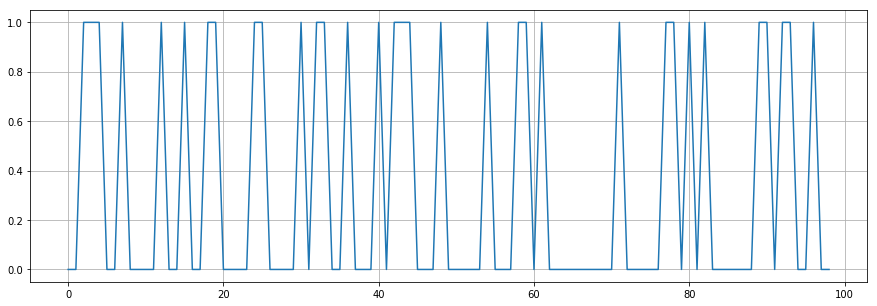

In [79]:
plt.figure(figsize=(15,5))
plt.plot(predictions[1:100])
plt.grid()

In [85]:
l=len(predictions)

In [88]:
y = val_gen_unbalanced.classes  # Extract the correct answers from the generator
y_=y[0:l]
len(y_)

174080

In [89]:

acc = accuracy_score(y_, predictions)
cm = confusion_matrix(y_, predictions)
tn, fp, fn, tp = cm.ravel()
precision = tp / (fp + tp)
recall = tp / (tp + fn)

print('accuracy', acc)
print('precision', precision)
print('recall', recall)

joblib.dump(scaler, 'scaler.pkl')
json.dump(hyperparameter_dict, open(f'{save_dir}/hyperparameters_dictionary.json', 'w'))

accuracy 0.551321231617647
precision 0.49373170996062
recall 0.35307187516147365


In [90]:
joblib.dump(scaler, 'scaler.pkl')
json.dump(hyperparameter_dict, open(f'{save_dir}/hyperparameters_dictionary.json', 'w'))